# Bagging Exercises

## Introduction

We will be using the customer churn data from the telecom industry that we used in week 1 for this week's exercises. The data file is called `Orange_Telecom_Churn_Data.csv`. 

### Prerequisites
Install imblearn and upgrade sklearn to 0.19.0

In [1]:
#!pip install imblearn
#!pip install --upgrade sklearn

In [2]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Import the customer churn data, which is found in the file `Orange_Telecom_Churn_Data.csv`. 
* Remove any columns that are likely not to be used for prediction.
* Encode data types as appropriate.

In [4]:
import pandas as pd
import numpy as np

file_path = os.sep.join(data_path+['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(file_path, sep=',')

In [5]:
data.head().T

,0,1,2,3,4
state,KS,OH,NJ,OH,OK
account_length,128,107,137,84,75
area_code,415,415,415,408,415
phone_number,382-4657,371-7191,358-1921,375-9999,330-6626
intl_plan,no,no,no,yes,yes
voice_mail_plan,yes,yes,no,no,no
number_vmail_messages,25,26,0,0,0
total_day_minutes,265.1,161.6,243.4,299.4,166.7
total_day_calls,110,123,114,71,113
total_day_charge,45.07,27.47,41.38,50.9,28.34


The prediction should definitely not include phone number. And it is unlikely that area code or state would be desired, unless there is some reason to assume the model has a very specific geographic factor.

In [6]:
data.drop(['state', 'phone_number', 'area_code'], axis=1, inplace=True)

Examine the data types. Everything looks OK other than `int_plan` and `voice_mail_plan` need to be boolean encoded.

In [7]:
data.dtypes

account_length                     int64
intl_plan                         object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churned                             bool
dtype: object

In [8]:
# data['intl_plan'] = data['intl_plan'].replace(['yes','no'],[1,0]).astype(np.bool)
for col in ['intl_plan', 'voice_mail_plan']:
    data[col] = data[col].replace('yes','True').replace('no','False').astype(np.bool)
    
    
data[['intl_plan', 'voice_mail_plan']].dtypes

intl_plan          bool
voice_mail_plan    bool
dtype: object

## Question 2

* Examine distribution of the predicted variable (`churned`).
* Split the data into train and test sets. Decide if a stratified split should be used or not based on the distribution.
* Examine the distribution of the predictor variable in the train and test data.

In [9]:
# Data are skewed at ~85% towards non-churned customers
# This will be important to remember when model building

data.churned.value_counts()

False    4293
True      707
Name: churned, dtype: int64

In [10]:
data.churned.value_counts(normalize=True)

False    0.8586
True     0.1414
Name: churned, dtype: float64

Given the skew in the predictor variable, let's split the data with the *churned* values being stratified.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

feature_cols = [x for x in data.columns if x != 'churned']

strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1500, random_state=45)
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols],data['churned']))

X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'churned']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'churned']

In [12]:
y_train.value_counts(normalize=True)

False    0.858571
True     0.141429
Name: churned, dtype: float64

In [13]:
y_test.value_counts(normalize=True)

False    0.858667
True     0.141333
Name: churned, dtype: float64

## Question 3

* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
* Plot the resulting oob errors as a function of the number of trees.

*Hint:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.

In [14]:
# Suppress warnings about too few trees from the early models

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True,
                            random_state=45,
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

for n_trees in [15,20,30,40,50,100,150,200,300,400]:
    
    rf.set_params(n_estimators=n_trees)
    rf.fit(X_train, y_train)
    
    # Get the oob error
    oob_error = 1 - rf.oob_score_
    
    # Store list
    oob_list.append(pd.Series({'n_trees':n_trees, 'oob':oob_error}))
    

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
rf_oob_df

,oob
n_trees,
15.0,0.086857
20.0,0.082286
30.0,0.078000
40.0,0.076000
50.0,0.072857
100.0,0.073143
150.0,0.071429
200.0,0.071714
300.0,0.072286


The error looks like it has stabilized around 100-150 trees.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

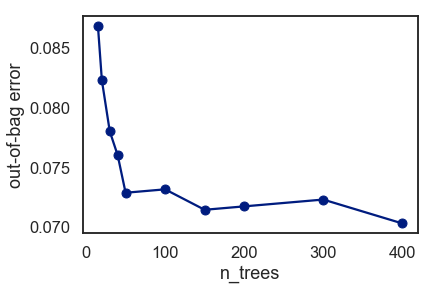

In [19]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error');

## Question 4

* Repeat question 3 using extra randomized trees (`ExtraTreesClassifier`). Note that the `bootstrap` parameter will have to be set to `True` for this model.
* Compare the out-of-bag errors for the two different types of models.

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,oob
n_trees,
15.0,0.100571
20.0,0.095429
30.0,0.090000
40.0,0.083143
50.0,0.081429
100.0,0.079429
150.0,0.080286
200.0,0.082000
300.0,0.078857


Combine the two dataframes into a single one for easier plotting.

In [21]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

oob_df

,RandomForest,ExtraTrees
n_trees,,
15.0,0.086857,0.100571
20.0,0.082286,0.095429
30.0,0.078000,0.090000
40.0,0.076000,0.083143
50.0,0.072857,0.081429
100.0,0.073143,0.079429
150.0,0.071429,0.080286
200.0,0.071714,0.082000
300.0,0.072286,0.078857


The random forest model performs consistently better than the extra randomized trees.

[Text(0,0.5,'out-of-bag-error')]

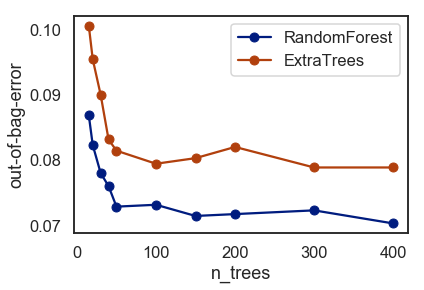

In [28]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = oob_df.plot(marker='o')
ax.set(ylabel='out-of-bag-error')

## Question 5

* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?

In [29]:
# Random forest with 100 estimators
model = rf.set_params(n_estimators=100)

y_pred = model.predict(X_test)

Unsurprisingly, recall is rather poor for the customers who churned (True) class since they are quite small. We are doing better than random guessing, though, as the accuracy is 0.932 (vs 0.85 for random guessing).

In [38]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuarcy':accuracy_score(y_test, y_pred),
                         'precision':precision_score(y_test, y_pred),
                         'recall':recall_score(y_test,y_pred),
                         'f1':f1_score(y_test, y_pred),
                         'auc':roc_auc_score(y_test,y_pred)},
                       index=pd.Index([0]))

score_df

              precision    recall  f1-score   support

       False       0.93      0.99      0.96      1288
        True       0.93      0.54      0.68       212

   micro avg       0.93      0.93      0.93      1500
   macro avg       0.93      0.77      0.82      1500
weighted avg       0.93      0.93      0.92      1500



,accuarcy,precision,recall,f1,auc
0,0.929333,0.934426,0.537736,0.682635,0.765762


## Question 6

* Print or visualize the confusion matrix.
* Plot the ROC-AUC and precision-recall curves.
* Plot the feature importances.

Text(0.5,4.5,'Ground Truth')

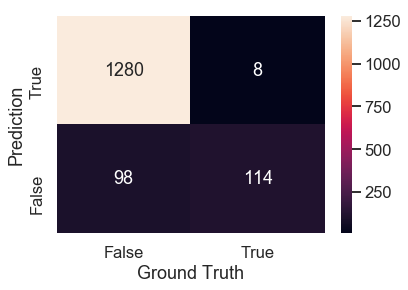

In [41]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels[::-1]);
ax.set_ylabel('Prediction');
ax.set_xlabel('Ground Truth')

The ROC-AUC and precision-recall curves.

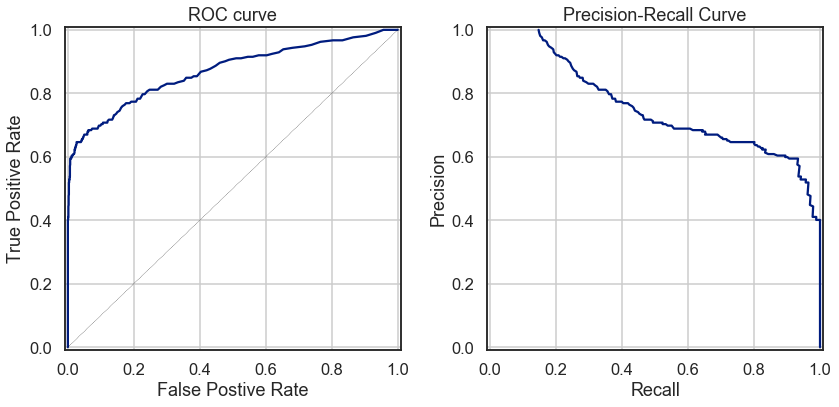

In [48]:
fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(12,6)

# Get the probabilities
y_proba = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr,tpr)

ax.plot([0,1],[0,1], ls='--',  color='black',lw=.3)
ax.set(title='ROC curve',
       xlim=[-.01,1.01],ylim=[-.01,1.01],
       ylabel='True Positive Rate',
       xlabel='False Postive Rate')
ax.grid(True)

# Plot the precision_recall curve
ax = axList[1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(precision,recall)
ax.set(ylabel='Precision',xlabel='Recall',
       xlim=[-.01,1.01],ylim=[-.01,1.01],
      title='Precision-Recall Curve')
ax.grid(True)

plt.tight_layout()

The feature importances. Total daily cost is the biggest predictor of customer churn.

In [50]:
feature_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

[Text(0,0.5,'Relative Importance')]

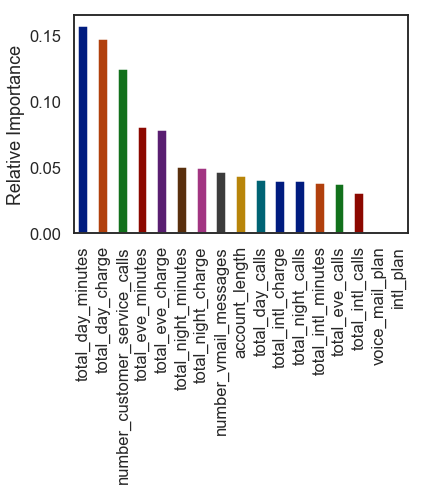

In [51]:
ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance')

### Churn data has lot of class imbalance. 
To fix it, use different sampling techniques like SMOTE, RamdomOverSampling .
Refer http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html

After fixing class imablance, check the metrics for different techniques.

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling as os_smote
from imblearn import under_sampling as us_smote
from imblearn import combine as cs_smote

## Question 7 

Create different objects using multiple smoting methods

Ex: os_sm = os_smote.SMOTE(random_state=45, ratio = 0.6)

#### Re-generate X_train and y_train using SMOTE object

Cross verify the value counts

In [65]:
X = data[feature_cols]
y = data['churned']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [85]:
X = data[feature_cols]
y = data['churned']

x_os,y_os = os_smote.SMOTE(random_state=45, ratio=0.6).fit_resample(X_train,y_train)
x_us,y_us = us_smote.RandomUnderSampler(random_state=45, ratio=0.6).fit_resample(X_train, y_train)
x_cs,y_cs = cs_smote.SMOTEENN(random_state=45, ratio=0.6).fit_resample(X_train, y_train)

In [86]:
np.bincount(y_os), np.bincount(y_us),np.bincount(y_cs)

(array([3012, 1807], dtype=int64),
 array([813, 488], dtype=int64),
 array([1899, 1529], dtype=int64))

## Question 8

* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
* Plot the resulting oob errors as a function of the number of trees.

*Hint:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.

*Note:* Use re-sampled data

In [92]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(oob_score=True,
                             random_state=45,
                             warm_start=True,
                            n_jobs=-1)

oob_list_os = list()

for n_trees in [15, 20, 25, 30, 50, 100, 150, 200, 300,400]:
    rfc.set_params(n_estimators=n_trees)
    rfc.fit(x_os, y_os)
    
    # The oob_error
    oob_error = 1 - rfc.oob_score_
    
    oob_list_os.append(pd.Series({'n_trees':n_trees, 'oob_os':oob_error}))
    
rf_oob_os_df = pd.concat(oob_list_os,axis=1).T.set_index('n_trees')
rf_oob_os_df

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,oob_os
n_trees,
15.0,0.095455
20.0,0.085495
25.0,0.080930
30.0,0.080722
50.0,0.071592
100.0,0.063706
150.0,0.063291
200.0,0.062669
300.0,0.062876


In [93]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(oob_score=True,
                             random_state=45,
                             warm_start=True,
                            n_jobs=-1)
oob_us_list = list()
for n_trees in [15, 20, 25, 30, 50, 100, 150, 200, 300,400]:
    rfc.set_params(n_estimators=n_trees)
    rfc.fit(x_us, y_us)
    
    # The oob error
    oob_error = 1 - rfc.oob_score_
    oob_us_list.append(pd.Series({'n_trees':n_trees, 'obb_us':oob_error}))
    
oob_us_df = pd.concat(oob_us_list, axis=1).T.set_index('n_trees')
oob_us_df

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,obb_us
n_trees,
15.0,0.206764
20.0,0.199078
25.0,0.196003
30.0,0.196772
50.0,0.190623
100.0,0.183705
150.0,0.184473
200.0,0.180630
300.0,0.182168


In [97]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(oob_score=True,
                             random_state=45,
                             warm_start=True,
                            n_jobs=-1)
oob_cs_list = list()
for n_trees in [15, 20, 25,30, 50, 100, 150, 200, 300, 400]:
    rfc.set_params(n_estimators=n_trees)
    rfc.fit(x_cs, y_cs)
    
    oob_error = 1 - rfc.oob_score_
    oob_cs_list.append(pd.Series({'n_trees':n_trees,'obb_cs':oob_error}))
    
oob_cs_df = pd.concat(oob_cs_list, axis=1).T.set_index('n_trees')
oob_cs_df

C:\Users\Bomera Moses\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,obb_cs
n_trees,
15.0,0.079638
20.0,0.064177
25.0,0.061844
30.0,0.058051
50.0,0.053092
100.0,0.047841
150.0,0.045216
200.0,0.044341
300.0,0.044049


In [103]:
oob_smote_df = pd.concat([rf_oob_os_df,oob_us_df, oob_cs_df], axis=1)
oob_smote_df

,oob_os,obb_us,obb_cs
n_trees,,,
15.0,0.095455,0.206764,0.079638
20.0,0.085495,0.199078,0.064177
25.0,0.080930,0.196003,0.061844
30.0,0.080722,0.196772,0.058051
50.0,0.071592,0.190623,0.053092
100.0,0.063706,0.183705,0.047841
150.0,0.063291,0.184473,0.045216
200.0,0.062669,0.180630,0.044341
300.0,0.062876,0.182168,0.044049


The error looks like it has stabilized around 100-150 trees.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

[Text(0,0.5,'out-of-bag-error')]

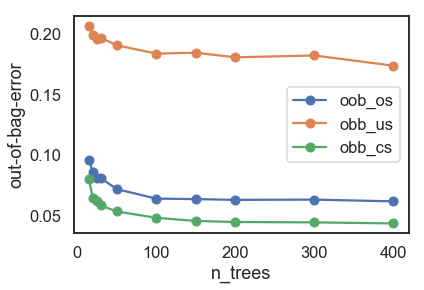

In [104]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('deep')

ax = oob_smote_df.plot(legend=True, marker='o')
ax.set(ylabel='out-of-bag-error')

## Question 9

* Repeat question 3 using extra randomized trees (`ExtraTreesClassifier`). Note that the `bootstrap` parameter will have to be set to `True` for this model.
* Compare the out-of-bag errors for the two different types of models.

In [119]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [120]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(oob_score=True,
                           random_state=45,
                           warm_start=True,
                           bootstrap=True,
                          n_jobs=-1)

oob_cs_etc = list()

for n_trees in [15, 20, 25, 30, 50, 100, 150, 200, 300, 400]:
    etc.set_params(n_estimators=n_trees)
    etc.fit(x_cs, y_cs)
    
    oob_error = 1 - etc.oob_score_
    oob_cs_etc.append(pd.Series({'n_trees':n_trees,'obb_cs_etc':oob_error}))
    
oob_cs_etc_df = pd.concat(oob_cs_etc, axis=1).T.set_index('n_trees')
oob_cs_etc_df
    

,obb_cs_etc
n_trees,
15.0,0.083139
20.0,0.067678
25.0,0.063594
30.0,0.060385
50.0,0.048425
100.0,0.037631
150.0,0.032380
200.0,0.032964
300.0,0.033547


Combine the two dataframes into a single one for easier plotting.

The random forest model performs consistently better than the extra randomized trees.

## Question 10

* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?

Unsurprisingly, recall is rather poor for the customers who churned (True) class since they are quite small. We are doing better than random guessing, though, as the accuracy is 0.932 (vs 0.85 for random guessing).

## Question 11

* Print or visualize the confusion matrix.
* Plot the ROC-AUC and precision-recall curves.
* Plot the feature importances.

The ROC-AUC and precision-recall curves.

The feature importances. Total daily cost is the biggest predictor of customer churn.